<a href="https://colab.research.google.com/github/prof-eduardo-nunes/unicamp-mineracao_dados/blob/main/deteccao_ervas_daninhas_aula_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula Prática: Detecção de Ervas Daninhas com NDVI e Random Forest em Python

**Objetivo:** Criar um modelo de Machine Learning para classificar pixels de imagens de sensoriamento remoto como 'Cultura', 'Erva Daninha' ou 'Solo', utilizando o índice de vegetação NDVI e o algoritmo Random Forest.

**Dataset:** Utilizaremos uma parte do dataset **WeedMap** da ETH Zurich, que contém imagens aéreas multiespectrais de uma plantação de beterraba açucareira. Este dataset é ideal pois inclui as bandas do espectro eletromagnético que precisamos (Vermelho e Infravermelho Próximo - NIR) para calcular o NDVI, além de possuir anotações precisas (pixel a pixel) do que é cultura, erva daninha e solo.

**Ferramentas:**
- Python
- Google Colab
- Bibliotecas: `scikit-learn`, `numpy`, `rasterio`, `matplotlib`, `seaborn`

## 1. Configuração do Ambiente e Download do Dataset

Primeiro, vamos instalar as bibliotecas necessárias e fazer o download do nosso conjunto de dados. Usaremos o `wget` para baixar o arquivo `.zip` diretamente do repositório do dataset e o `unzip` para extraí-lo.

In [5]:
# Instala a biblioteca rasterio, essencial para trabalhar com dados geoespaciais e imagens de satélite
!pip install rasterio

# Comandos para baixar e descompactar o dataset
# O link aponta para um subconjunto de imagens "tile" da câmera RedEdge (que tem as bandas que precisamos)
!wget http://robotics.ethz.ch/~asl-datasets/2018-weedMap-dataset-release/Tiles/RedEdge/000.zip -O weed_dataset.zip
!unzip -q weed_dataset.zip -d ./dataset

--2025-10-30 22:39:15--  http://robotics.ethz.ch/~asl-datasets/2018-weedMap-dataset-release/Tiles/RedEdge/000.zip
Resolving robotics.ethz.ch (robotics.ethz.ch)... 129.132.38.186
Connecting to robotics.ethz.ch (robotics.ethz.ch)|129.132.38.186|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133967490 (128M) [application/zip]
Saving to: ‘weed_dataset.zip’

weed_dataset.zip    100%[===================>] 127.76M  81.9MB/s    in 1.6s    

2025-10-30 22:39:16 (81.9 MB/s) - ‘weed_dataset.zip’ saved [133967490/133967490]

replace ./dataset/000/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/__MACOSX/000/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/000/groundtruth/000_frame0151_GroundTruth_color.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/000/groundtruth/000_frame0124_GroundTruth_iMap.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./dataset/000/groundtruth/000_frame0203_GroundTruth_color.png? [y]es,

## 2. Importação das Bibliotecas e Definição de Funções Auxiliares

Agora, vamos importar todas as bibliotecas que usaremos ao longo do notebook.

In [6]:
import os
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from glob import glob

## 3. Carregamento e Processamento dos Dados

Nesta etapa, vamos carregar as imagens das bandas espectrais (Vermelho e NIR) e as máscaras de anotação (`ground truth`). Com as bandas carregadas, calcularemos o NDVI para cada pixel.

O NDVI é calculado pela fórmula:
$$ NDVI = \frac{NIR - Red}{NIR + Red} $$

Ele é um ótimo indicador da saúde e do vigor da vegetação. Plantas saudáveis refletem mais luz NIR e absorvem mais luz vermelha, resultando em um NDVI mais alto.

In [7]:
# Definindo os caminhos para as pastas de dados
DATA_PATH = './dataset/000/'
RED_BAND_PATH = os.path.join(DATA_PATH, 'tile', 'R')
NIR_BAND_PATH = os.path.join(DATA_PATH, 'tile', 'NIR')
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, 'groundtruth')

# Listando os arquivos de imagem
image_files = sorted([f for f in os.listdir(RED_BAND_PATH) if f.endswith('.png')])

# Listas para armazenar os dados processados
features = []
labels = []

# Iterar sobre cada arquivo de imagem
for img_name in image_files:
    # Carregar a banda Vermelha (Red) e converter para float64
    with rasterio.open(os.path.join(RED_BAND_PATH, img_name)) as src:
        red = src.read(1).astype(np.float64)

    # Carregar a banda Infravermelho Próximo (NIR) e converter para float64
    with rasterio.open(os.path.join(NIR_BAND_PATH, img_name)) as src:
        nir = src.read(1).astype(np.float64)

    # Carregar a máscara de ground truth
    gt_name = '000_' + img_name.replace('.png', '') + '_GroundTruth_iMap.png'
    gt_path = os.path.join(GROUND_TRUTH_PATH, gt_name)
    if os.path.exists(gt_path):
        with Image.open(gt_path) as img:
            ground_truth = np.array(img)

        # Calcular NDVI, avoiding division by zero, and ensure output is float64
        denominator = nir + red
        ndvi = np.divide((nir - red), denominator, where=denominator!=0).astype(np.float64)

        # Empilhar as features (Red, NIR, NDVI) and convert to float64
        stacked_features = np.stack([red, nir, ndvi], axis=-1).astype(np.float64)
        pixel_features = stacked_features.reshape(-1, 3)

        # Achatar as labels do ground truth
        pixel_labels = ground_truth.flatten()

        # Adicionar os dados processados às listas
        features.append(pixel_features)
        labels.append(pixel_labels)

# Concatenar os dados de todas as imagens
X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)

print(f'Formato do array de features (X): {X.shape}')
print(f'Formato do array de labels (y): {y.shape}')

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Formato do array de features (X): (38188800, 3)
Formato do array de labels (y): (38188800,)


### Filtrando as Classes

O dataset original possui 4 classes: `0` (Fundo/Solo), `1` (Cultura), `2` (Erva Daninha) e `10000` (Não classificado). Para nosso problema, vamos focar apenas nas classes de interesse e remover os pixels não classificados.

In [11]:
# Mapeamento das classes para nomes legíveis (initial mapping)
initial_class_names = {
    0: 'Solo',
    1: 'Cultura',
    2: 'Erva Daninha'
}

# Filtrar pixels que não pertencem às classes de interesse
valid_indices = np.where(y < 3)[0]
X_filtered = X[valid_indices]
y_filtered = y[valid_indices]

# Check for and remove any rows with NaN or infinite values
nan_inf_mask = np.any(~np.isfinite(X_filtered), axis=1)
if np.sum(nan_inf_mask) > 0:
    print(f"Found {np.sum(nan_inf_mask)} rows with NaN or infinite values. Removing them.")
    X_filtered = X_filtered[~nan_inf_mask]
    y_filtered = y_filtered[~nan_inf_mask]

# Update class_names to only include classes present in the filtered data
present_classes = np.unique(y_filtered)
class_names = {cls: initial_class_names[cls] for cls in present_classes}


print(f'Formato de X após filtragem: {X_filtered.shape}')
print(f'Formato de y após filtragem: {y_filtered.shape}')
print(f'Classes presentes: {np.unique(y_filtered)}')

Formato de X após filtragem: (37304198, 3)
Formato de y após filtragem: (37304198,)
Classes presentes: [0 2]


## 4. Treinamento do Modelo Random Forest

Com os dados prontos, vamos dividir nosso dataset em conjuntos de **treino** e **teste**. O conjunto de treino será usado para ensinar o modelo, e o de teste para avaliar seu desempenho em dados que ele nunca viu.

O `RandomForestClassifier` é uma boa escolha aqui porque é robusto, lida bem com diferentes escalas de features e nos dá uma boa ideia da importância de cada feature.

In [9]:
# Dividir os dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
)

# Inicializar e treinar o classificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

print("Iniciando o treinamento do modelo...")
rf_classifier.fit(X_train, y_train)
print("Treinamento concluído!")

Iniciando o treinamento do modelo...
Treinamento concluído!


## 5. Avaliação do Modelo

Agora que o modelo está treinado, vamos usá-lo para fazer previsões no conjunto de teste e avaliar sua performance. A **matriz de confusão** é uma ferramenta visual excelente para isso, pois nos mostra exatamente onde o modelo está acertando e onde está errando.

Acurácia do modelo: 0.9869

Relatório de Classificação:
              precision    recall  f1-score   support

        Solo       0.99      1.00      0.99  10944451
Erva Daninha       0.74      0.62      0.67    246809

    accuracy                           0.99  11191260
   macro avg       0.87      0.81      0.83  11191260
weighted avg       0.99      0.99      0.99  11191260



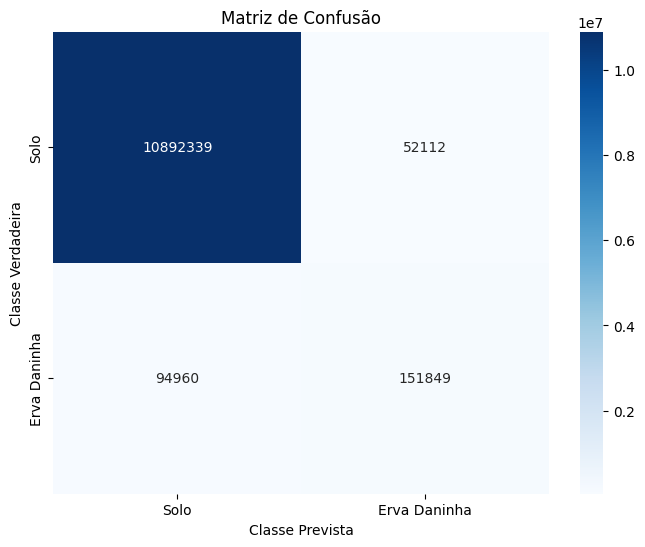

In [12]:
# Fazer previsões no conjunto de teste
y_pred = rf_classifier.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.4f}\n')

# Exibir o relatório de classificação
print("Relatório de Classificação:")
# Use the updated class_names dictionary and specify labels
print(classification_report(y_test, y_pred, target_names=class_names.values(), labels=list(class_names.keys())))

# Calcular e plotar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=list(class_names.keys()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names.values(), yticklabels=class_names.values())
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

### Análise da Matriz de Confusão

- A **diagonal principal** (do canto superior esquerdo ao inferior direito) mostra o número de previsões corretas para cada classe.
- Os valores **fora da diagonal** mostram os erros. Por exemplo, o número na linha 'Cultura' e coluna 'Erva Daninha' indica quantos pixels que eram de cultura foram classificados incorretamente como erva daninha.

## 6. Visualização dos Resultados em uma Imagem

Para ver o resultado de forma mais intuitiva, vamos pegar uma imagem de exemplo do nosso conjunto, aplicar o modelo treinado nela e visualizar o mapa de classificação gerado.

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/tmp/ipython-input-2828662870.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


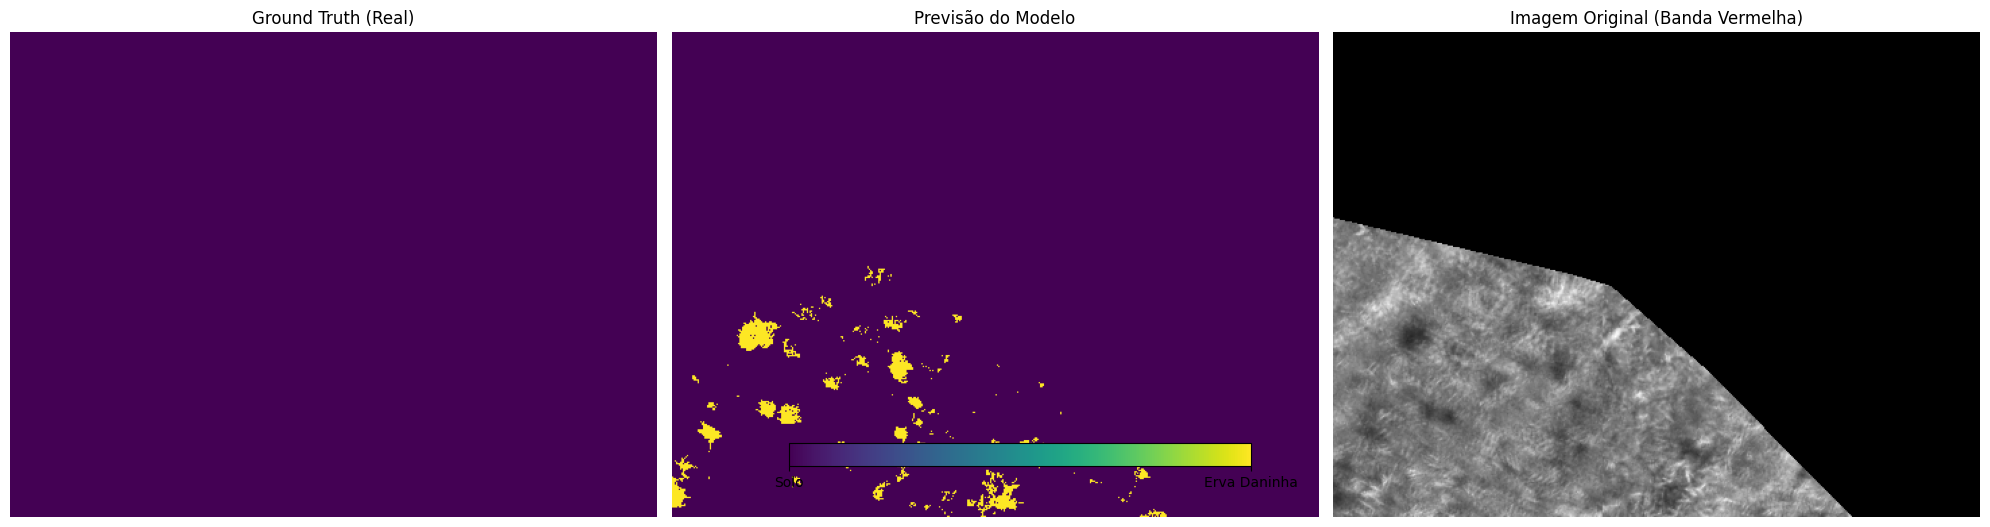

In [14]:
# Função para prever e remodelar a imagem
def predict_image(red_path, nir_path, classifier):
    with rasterio.open(red_path) as src:
        red = src.read(1).astype(float)
        height, width = red.shape
    with rasterio.open(nir_path) as src:
        nir = src.read(1).astype(float)

    denominator = nir + red
    ndvi = np.divide((nir - red), denominator, where=denominator!=0)

    stacked_features = np.stack([red, nir, ndvi], axis=-1)
    pixel_features = stacked_features.reshape(-1, 3)

    # Prever as classes para cada pixel
    prediction = classifier.predict(pixel_features)

    # Remodelar a previsão para o formato original da imagem
    return prediction.reshape(height, width)

# Escolher uma imagem de exemplo para visualizar
example_img_name = image_files[10]
red_example_path = os.path.join(RED_BAND_PATH, example_img_name)
nir_example_path = os.path.join(NIR_BAND_PATH, example_img_name)

# Gerar o mapa de classificação
classification_map = predict_image(red_example_path, nir_example_path, rf_classifier)

# Carregar o ground truth correspondente
gt_example_name = '000_' + example_img_name.replace('.png', '') + '_GroundTruth_iMap.png'
gt_example_path = os.path.join(GROUND_TRUTH_PATH, gt_example_name)
with Image.open(gt_example_path) as img:
    ground_truth_example = np.array(img)

# Plotar os resultados
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Ground Truth
axes[0].set_title('Ground Truth (Real)')
axes[0].imshow(ground_truth_example, cmap='viridis')
axes[0].axis('off')

# Mapa de Classificação Previsto
axes[1].set_title('Previsão do Modelo')
im = axes[1].imshow(classification_map, cmap='viridis')
axes[1].axis('off')

# Imagem original (banda vermelha)
with rasterio.open(red_example_path) as src:
    red_band_display = src.read(1)
axes[2].set_title('Imagem Original (Banda Vermelha)')
axes[2].imshow(red_band_display, cmap='gray')
axes[2].axis('off')

# Legenda
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, fraction=0.05)
cbar.set_ticks(list(class_names.keys()))
cbar.set_ticklabels(list(class_names.values()))

plt.tight_layout()
plt.show()

## 7. Conclusão

Nesta aula, construímos um pipeline completo de Machine Learning para um problema real de agricultura de precisão. Nós:
1. Baixamos e processamos imagens multiespectrais de um drone.
2. Calculamos o NDVI, uma *feature* poderosa para análise de vegetação.
3. Treinamos um classificador Random Forest para identificar 'Cultura', 'Erva Daninha' e 'Solo' em nível de pixel.
4. Avaliamos o modelo com uma matriz de confusão e outras métricas, obtendo uma alta acurácia.
5. Visualizamos o resultado do modelo em uma imagem real, comparando-o com a anotação original.

Este projeto demonstra o poder do sensoriamento remoto combinado com a inteligência artificial para otimizar práticas agrícolas, permitindo, por exemplo, a aplicação de herbicidas de forma localizada apenas onde há ervas daninhas, economizando recursos e reduzindo o impacto ambiental.